# 导入库及自定义函数

## 库

In [1]:
import cv2
import numpy as np
import sys
from matplotlib import pyplot as plt
import os, random, shutil
import torch
import torch.nn.functional as F
import torch.optim as optim
import torch.nn as nn
from itertools import cycle
from torchvision import datasets
from torch.autograd import Variable
import torchvision
from torchvision.transforms import transforms
from visdom import Visdom
from torch.utils.data import Dataset, DataLoader, TensorDataset,ConcatDataset

## 自定义函数

In [2]:
def pltshow(img):
    """
    介绍：在Jupyter界面上展示图片。转变了numpy数组的颜色空间，使图片色彩符合直觉 \n
    传入变量： \n
            img:传入的图片 \n
    传出变量： \n
            无 \n
    """
    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) #颜色空间转换函数
    plt.imshow(img, cmap = 'gray', interpolation = 'bicubic')
    plt.xticks([]), plt.yticks([]) # 隐藏 X 和 Y 轴的刻度值
    plt.show()

# 训练集制作

## 移动

In [33]:
"""
img_dir='images/'
name_list=os.listdir(img_dir)
sum=0
for name in name_list:
    if os.path.exists(img_dir+name+'/Out_image.jpg'):
        sum+=1
        with open(img_dir+name+'/label.txt') as f1:
            with open('datas/label/'+str(sum)+'.txt','w') as f2:
                f2.write(f1.read())
        im=cv2.imread(img_dir+name+'/Ori_image.jpg')
        cv2.imwrite('datas/images/'+str(sum)+'.jpg',im)
"""
print("移动")

移动


## 划分训练集和验证集

In [34]:
"""
def moveimg(fileDir, tarDir):
    pathDir = os.listdir(fileDir)  # 取图片的原始路径
    filenumber = len(pathDir)
    rate = 0.1  # 自定义抽取图片的比例，比方说100张抽10张，那就是0.1
    picknumber = int(filenumber * rate)  # 按照rate比例从文件夹中取一定数量图片
    sample = random.sample(pathDir, picknumber)  # 随机选取picknumber数量的样本图片
    print(sample)
    for name in sample:
        shutil.move(fileDir + name, tarDir + "/" + name)
    return
 
def movelabel(file_list, file_label_train, file_label_val):
    for i in file_list:
        if i.endswith('.jpg'):
            # filename = file_label_train + "\\" + i[:-4] + '.xml'  # 可以改成xml文件将’.txt‘改成'.xml'就可以了
            filename = file_label_train + "/" + i[:-4] + '.txt'  # 可以改成xml文件将’.txt‘改成'.xml'就可以了
            if os.path.exists(filename):
                shutil.move(filename, file_label_val)
                print(i + "处理成功！")
if __name__ == '__main__':
    fileDir = r'datas/images'+ "/"  # 源图片文件夹路径
    tarDir = r'datas/images_val'  # 图片移动到新的文件夹路径
    moveimg(fileDir, tarDir)
    file_list = os.listdir(tarDir)
    file_label_train = 'datas/labels' # 源图片标签路径
    file_label_val = 'datas/labels_val'  # 标签
      # 移动到新的文件路径
    movelabel(file_list, file_label_train, file_label_val)
"""
print("划分")

划分


# 训练

## 相关自定义函数

### DataLoader制作函数

In [22]:
def Make_loader(data_train,data_label,batch_size=200, shuffle=False):
    """
    介绍：制作DataLoader \n
    传入变量: \n
            data_train:传入的图片集合 \n
            data_label:传入的标签集合 \n
            batch_size:每一组的数据数量，用于划分训练集 \n
            shuffle:是否对传入的数据及进行随机打乱 \n
    传出变量： \n
            data_loader:传出制作好的DataLoader \n
    """
    
    dataset = TensorDataset(data_train,data_label)
    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)#shuffle是是否打乱数据集，可自行设置

    return data_loader

### 数据集读取和制作函数

In [23]:
def get_loader(fileDir,tarDir,file_label_train,file_label_val,batch_size=200,shuffle=False):
    """
    介绍：从文件中读取数据并制作数据集 \n
    传入变量: \n
            fileDir:训练图片文件夹路径 \n
            tarDir:验证图片文件夹路径 \n
            file_label_train:训练标签文件夹路径 \n
            file_label_val:验证标签文件夹路径 \n
            batch_size:每一组的数据数量，用于划分训练集 \n
            shuffle:是否对传入的数据及进行随机打乱 \n
    传出变量： \n
            train_loader:传出制作好的训练数据集 \n
            test_loader:传出制作好的验证数据集 \n
    """
    
    transf = torchvision.transforms.ToTensor()  # 实例化类
    device=torch.device('cuda:0')  #在GPU上运行
    
    img_list=[]
    label_list=[]
    img_list_val=[]
    label_list_val=[]
    name_list = os.listdir(fileDir)
    name_val_list = os.listdir(tarDir)
    for name in name_list:
        f=open(file_label_train+'/'+name[:-4]+'.txt')
        text=f.read()
        if text=='':
            print('训练集 '+name+' 的标签为空')
            f.close()
        else:
            im=cv2.imread(fileDir+'/'+name)
            #lenth=max([im.shape[0],im.shape[1]])
            List=text.split('[')[1].split(']')[0].split(',')
            for i in range(4):
                List[i*2]=float(List[i*2])/im.shape[1]
                List[i*2+1]=float(List[i*2+1])/im.shape[0]
            label_list.append(List)
            im=cv2.resize(im,(Resize_num, Resize_num), interpolation = cv2.INTER_CUBIC)
            img_list.append(transf(im))
            f.close

    for name in name_val_list:
        f=open(file_label_val+'/'+name[:-4]+'.txt')
        text=f.read()
        if text=='':
            print('训练集 '+name+' 的标签为空')
            f.close()
        else:
            im=cv2.imread(tarDir+'/'+name)
            #lenth=max([im.shape[0],im.shape[1]])
            List=text.split('[')[1].split(']')[0].split(',')
            for i in range(4):
                List[i*2]=float(List[i*2])/im.shape[1]
                List[i*2+1]=float(List[i*2+1])/im.shape[0]
            label_list_val.append(List)
            im=cv2.resize(im,(Resize_num, Resize_num), interpolation = cv2.INTER_CUBIC)
            img_list_val.append(transf(im))
            f.close


    data=torch.stack(img_list)
    data_val=torch.stack(img_list_val)
    target=torch.tensor(label_list)
    target_val=torch.tensor(label_list_val)

    data=data.to(torch.float32)
    data_val=data_val.to(torch.float32)
    target=target.to(torch.float32)
    target_val=target_val.to(torch.float32)
                        
    print('')
    print('训练图片集规模：',data.shape)
    print('训练标签集规模：',target.shape)
    print('验证图片集规模：',data_val.shape)
    print('验证标签集规模：',target_val.shape)
    
    train_loader,test_loader=Make_loader(data,target,batch_size,shuffle) , Make_loader(data_val,target_val,batch_size,False)
    return train_loader,test_loader  

### ResNet34

In [24]:
class ResNet34(nn.Module): # 定义ResNet类，也就是构建残差网络结构 （2）
    """实现主module：ResNet34"""
    def __init__(self,numclasses=1000): # 创建实例时直接初始化 （3）
        super(ResNet34, self).__init__() # 表示ResNet继承nn.Module （4）
        self.pre = nn.Sequential( # 构建Sequential，属于特殊的module，类似于forward前向传播函数，同样的方式调用执行 （5）（26）
            nn.Conv2d(3,64,7,2,3,bias=False),  # 卷积层，输入通道数为3，输出通道数为64，包含在Sequential的子module，层层按顺序自动执行
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(3,2,1)
        )

        self.layer1 = self.make_layer(64,128,4) # 输入通道数为64，输出为128，根据残差网络结构将一个非Residual Block加上多个Residual Block构造成一层layer（6）
        self.layer2 = self.make_layer(128,256,4,stride=2) #  输入通道数为128，输出为256 （18，流程重复所以标注省略7-17过程）
        self.layer3 = self.make_layer(256,256,6,stride=2) #  输入通道数为256，输出为256 （19，流程重复所以标注省略7-17过程）
        self.layer4 = self.make_layer(256,512,3,stride=2) #  输入通道数为256，输出为512 （20，流程重复所以标注省略7-17过程）

        self.fc = nn.Linear(512,numclasses) # 全连接层，属于残差网络结构的最后一层，输入通道数为512，输出为numclasses （21）

    def make_layer(self,inchannel,outchannel,block_num,stride=1): # 创建layer层，（block_num-1）表示此层中Residual Block的个数 （7）
        """构建layer，包含多个residualblock"""
        shortcut = nn.Sequential( # 构建Sequential，属于特殊的module，类似于forward前向传播函数，同样的方式调用执行 （8）
            nn.Conv2d(inchannel,outchannel,1,stride,bias=False),
            nn.BatchNorm2d(outchannel)
        )
        layers = [] # 创建一个列表，将非Residual Block和多个Residual Block装进去 （9）
        layers.append(ResidualBlock(inchannel,outchannel,stride,shortcut)) # 非残差也就是非Residual Block创建及入列表 （10）

        for i in range(1,block_num):
            layers.append(ResidualBlock(outchannel,outchannel)) # 残差也就是Residual Block创建及入列表 （16）

        return nn.Sequential(*layers) # 通过nn.Sequential函数将列表通过非关键字参数的形式传入，并构成一个新的网络结构以Sequential形式构成，一个非Residual Block和多个Residual Block分别成为此Sequential的子module，层层按顺序自动执行，并且类似于forward前向传播函数，同样的方式调用执行 （17） （28）

    def forward(self,x): # ResNet类的前向传播函数 （24）
        x = self.pre(x)  # 和调用forward一样如此调用pre这个Sequential（25）

        x = self.layer1(x) # 和调用forward一样如此调用layer1这个Sequential（27）
        x = self.layer2(x) # 和调用forward一样如此调用layer2这个Sequential（39，流程重复所以标注省略28-38过程）
        x = self.layer3(x) # 和调用forward一样如此调用layer3这个Sequential（40，流程重复所以标注省略28-38过程）
        x = self.layer4(x) # 和调用forward一样如此调用layer4这个Sequential（41，流程重复所以标注省略28-38过程）

        x = F.avg_pool2d(x,7) # 平均池化 （42）
        x = x.view(x.size(0),-1) # 设置返回结果的尺度 （43）
        return self.fc(x) # 返回结果 （44）

### 网络训练函数

In [25]:
def train(model,train_loader,test_loader,learn_rate,epochs):
    """
    介绍：网路训练函数。训练可中断，同时保留训练效果。本函数使用了visdom以可视化数据。使用命令 python -m visdom.server 打开visdom \n
         可视化训练效果网址：http://localhost:8097 \n
    传入变量: \n
            model:要训练的模型 \n
            train_loader:训练数据集 \n
            test_loader:验证数据集 \n
            tarDir:验证图片文件夹路径 \n
            learn_rate:学习率 \n
            epochs:训练轮数 \n
            batch_size:每一组的数据数量，用于划分训练集 \n
    传出变量： \n
            无 \n
    """
    
    device=torch.device('cuda:0')  #在GPU上运行

    optimizer=torch.optim.Adam(model.parameters(), learn_rate)
    loss_fun=nn.MSELoss().to(device)

    #使用命令 python -m visdom.server 打开visdom
    #网址：http://localhost:8097
    viz=Visdom()
    viz.line([0.],[0.],win='train_loss',opts=dict(title='train loss'))
    viz.line([[0.0,0.0]],[0.],win='test',opts=dict(title='test loss&acc',
                                               legend=['loss','acc']))
    viz.line([0.],[0.],win='acc',opts=dict(title='acc'))
    viz.line([0.],[0.],win='test_loss',opts=dict(title='test loss'))

    step_Tr=0
    step_Te=0

    for epoch in range(epochs):
    
        for batch_idx,(data,target) in enumerate(train_loader):
        
            step_Tr+=1
        
            data,target=data.to(device),target.to(device)
        
            logits=model(data)
            loss=loss_fun(logits,target)
        
            viz.line([loss.item()],[step_Tr],win='train_loss',update='append')
        
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
            if batch_idx %100.==0:
                print('训练轮数: {} [{}/{} ({:.0f}%) ]\tLoss: {:.9f}'.format(
                    epoch,batch_idx*len(data),len(train_loader.dataset),
                        100*(batch_idx*len(data))/len(train_loader.dataset),loss.item()))
        test_loss=0
        correct=0
        step_Te+=1
        
        for data,target in test_loader:
        
            data,target=data.to(device),target.to(device)
            with torch.no_grad():
                logits=model(data)
            test_loss+=loss_fun(logits,target).item()*len(data)
    
            pred=logits.data
            for x in range(len(target)):
                
                flag=True
                for y in range(8):
                    if abs(target[x][y]-pred[x][y])>0.01:
                        flag=False
                if flag:
                    correct+=1
                    
                flag=True
                for y in range(8):
                    if pred[x][y]>0.001 or target[x][y]>0.001:
                        flag=False
                if flag:
                    correct+=1
                    
                    
        
        test_loss/=len(test_loader.dataset)

        viz.line([[test_loss,correct/len(test_loader.dataset)]],
                        [step_Te],win='test',update='append')
        viz.line([100*correct/len(test_loader.dataset)],[step_Te],win='acc',update='append')
        viz.line([test_loss],[step_Te],win='test_loss',update='append')
    
        print('\n结果验证: 平均损失: {:.9f},准确率: {}/{} ({:.0f}%)\n'.format(
            test_loss,correct,len(test_loader.dataset), 
        100.*correct/len(test_loader.dataset)))

    print('训练结束！')

### 网络保存函数

In [26]:
def model_save(model,path):
    """
    介绍：保存模型为权重文件 \n
    传入变量: \n
            model:要保存权重的模型 \n
            path:要保存的路径 \n
    传出变量： \n
            无 \n
    """
    torch.save(model.state_dict(),path)

### 权重加载函数

In [27]:
def model_load(model,path):
    """
    介绍：将权重文件加载到模型上 \n
    传入变量: \n
            model:要加载权重的模型 \n
            path:要加载的权重的路径 \n
    传出变量： \n
            无 \n
    """
    model.load_state_dict(torch.load(path))

### 合并两个DataLoader

In [28]:
def Merge_loader(Loader_1, Loader_2, batch_size, shuffle):
    """
    介绍：本函数可混合两个DataLoader \n
    传入变量: \n
            Loader_1:混合对象1 \n
            Loader_2:混合对象2 \n
            batch_size:每个batch的size \n
            shuffle:是否随即打乱数据 \n
    传出变量： \n
            merged_dataloader:混合后的DataLoader \n
    """
    
    # 将两个 DataLoader 的数据集合并为一个 ConcatDataset 对象
    dataset_1=Loader_1.dataset
    
    img_list=[]
    label_list=[]
    for x in range(len(Loader_2.dataset)):
        img_list.append(Loader_2.dataset[x][0])
        label_list.append(Loader_2.dataset[x][1])
        
    data=torch.stack(img_list)
    target=torch.tensor(label_list)
    data=data.to(torch.float32)
    target=target.to(torch.long)
    
    dataset_2 = TensorDataset(data,target)
        
    concat_dataset = ConcatDataset([dataset_1,dataset_2])
    
    # 创建合并后的 DataLoader 对象
    merged_dataloader = DataLoader(concat_dataset, batch_size=batch_size, shuffle=shuffle)

    return merged_dataloader

## 网络训练

### 需要的参数

In [17]:
learn_rate=1e-4   #学习率，防止过拟合
epochs=800   #训练轮数
batch_size=3   #数据集的划分量
shuffle=True   #生成数据集时是否打乱

### 制作data_loader

In [18]:
train_loader,test_loader=get_loader('datas/images','datas/images_val','datas/labels','datas/labels_val',batch_size,shuffle)

FileNotFoundError: [Errno 2] No such file or directory: 'datas/images'

### 新建网络

In [19]:
device=torch.device('cuda:0')  #在GPU上运行
let=ResNet18().to(device)

### 训练(可中断，模型传入为地址)

In [6]:
"""
本函数使用了visdom以可视化数据
使用命令 python -m visdom.server 打开visdom
可视化训练效果网址：http://localhost:8097
"""
train(let,train_loader,test_loader,learn_rate,epochs)

Setting up a new session...


训练轮数: 0 [0/2953 (0%) ]	Loss: 0.006769764
训练轮数: 0 [300/2953 (10%) ]	Loss: 0.350120723
训练轮数: 0 [600/2953 (20%) ]	Loss: 0.314129889
训练轮数: 0 [900/2953 (30%) ]	Loss: 0.214330733
训练轮数: 0 [1200/2953 (41%) ]	Loss: 0.068194896
训练轮数: 0 [1500/2953 (51%) ]	Loss: 0.290579796
训练轮数: 0 [1800/2953 (61%) ]	Loss: 0.450480759
训练轮数: 0 [2100/2953 (71%) ]	Loss: 0.148142695
训练轮数: 0 [2400/2953 (81%) ]	Loss: 0.085236728
训练轮数: 0 [2700/2953 (91%) ]	Loss: 0.198424026

结果验证: 平均损失: 16.970869865,准确率: 0/327 (0%)

训练轮数: 1 [0/2953 (0%) ]	Loss: 6.084174156
训练轮数: 1 [300/2953 (10%) ]	Loss: 7.652320862
训练轮数: 1 [600/2953 (20%) ]	Loss: 0.881792903
训练轮数: 1 [900/2953 (30%) ]	Loss: 0.386546224
训练轮数: 1 [1200/2953 (41%) ]	Loss: 0.825242639
训练轮数: 1 [1500/2953 (51%) ]	Loss: 0.277505338
训练轮数: 1 [1800/2953 (61%) ]	Loss: 0.218399033
训练轮数: 1 [2100/2953 (71%) ]	Loss: 0.147597894
训练轮数: 1 [2400/2953 (81%) ]	Loss: 0.222732514
训练轮数: 1 [2700/2953 (91%) ]	Loss: 0.113028824

结果验证: 平均损失: 0.224172493,准确率: 0/327 (0%)

训练轮数: 2 [0/2953 (0%) ]	Loss: 

训练轮数: 16 [2700/2953 (91%) ]	Loss: 0.055597544

结果验证: 平均损失: 0.118656716,准确率: 2/327 (1%)

训练轮数: 17 [0/2953 (0%) ]	Loss: 0.086213112
训练轮数: 17 [300/2953 (10%) ]	Loss: 0.447246283
训练轮数: 17 [600/2953 (20%) ]	Loss: 0.088332877
训练轮数: 17 [900/2953 (30%) ]	Loss: 0.085679442
训练轮数: 17 [1200/2953 (41%) ]	Loss: 0.085474715
训练轮数: 17 [1500/2953 (51%) ]	Loss: 0.042383816
训练轮数: 17 [1800/2953 (61%) ]	Loss: 0.538108766
训练轮数: 17 [2100/2953 (71%) ]	Loss: 0.088259563
训练轮数: 17 [2400/2953 (81%) ]	Loss: 0.119816497
训练轮数: 17 [2700/2953 (91%) ]	Loss: 0.085092448

结果验证: 平均损失: 0.171236336,准确率: 2/327 (1%)

训练轮数: 18 [0/2953 (0%) ]	Loss: 0.061561711
训练轮数: 18 [300/2953 (10%) ]	Loss: 0.299041599
训练轮数: 18 [600/2953 (20%) ]	Loss: 0.139197156
训练轮数: 18 [900/2953 (30%) ]	Loss: 0.062888168
训练轮数: 18 [1200/2953 (41%) ]	Loss: 0.128348798
训练轮数: 18 [1500/2953 (51%) ]	Loss: 0.411750644
训练轮数: 18 [1800/2953 (61%) ]	Loss: 0.139734343
训练轮数: 18 [2100/2953 (71%) ]	Loss: 0.102647386
训练轮数: 18 [2400/2953 (81%) ]	Loss: 0.093329273
训练轮数: 18 [

训练轮数: 33 [1500/2953 (51%) ]	Loss: 0.038610574
训练轮数: 33 [1800/2953 (61%) ]	Loss: 0.039549988
训练轮数: 33 [2100/2953 (71%) ]	Loss: 0.042683061
训练轮数: 33 [2400/2953 (81%) ]	Loss: 0.217414200
训练轮数: 33 [2700/2953 (91%) ]	Loss: 0.178997815

结果验证: 平均损失: 0.170265636,准确率: 1/327 (0%)

训练轮数: 34 [0/2953 (0%) ]	Loss: 0.535923362
训练轮数: 34 [300/2953 (10%) ]	Loss: 0.206902564
训练轮数: 34 [600/2953 (20%) ]	Loss: 0.050936528
训练轮数: 34 [900/2953 (30%) ]	Loss: 0.144789532
训练轮数: 34 [1200/2953 (41%) ]	Loss: 0.235308677
训练轮数: 34 [1500/2953 (51%) ]	Loss: 0.104487352
训练轮数: 34 [1800/2953 (61%) ]	Loss: 0.087548167
训练轮数: 34 [2100/2953 (71%) ]	Loss: 0.107725859
训练轮数: 34 [2400/2953 (81%) ]	Loss: 0.188129708
训练轮数: 34 [2700/2953 (91%) ]	Loss: 0.557248771

结果验证: 平均损失: 1.924136741,准确率: 0/327 (0%)

训练轮数: 35 [0/2953 (0%) ]	Loss: 3.010604382
训练轮数: 35 [300/2953 (10%) ]	Loss: 3.520228863
训练轮数: 35 [600/2953 (20%) ]	Loss: 1.823060751
训练轮数: 35 [900/2953 (30%) ]	Loss: 0.043723147
训练轮数: 35 [1200/2953 (41%) ]	Loss: 0.027626213
训练轮数: 35 [

KeyboardInterrupt: 

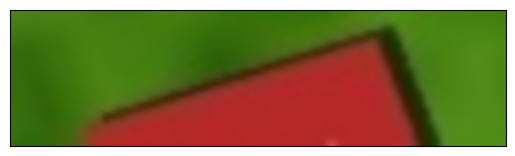

这张没法转正捏


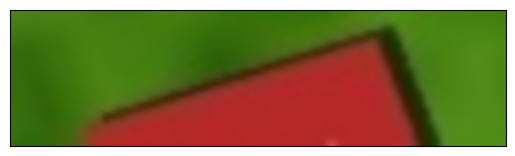

In [11]:
im=cv2.imread('4.jpg')
pltshow(im)
List,im=testimg(im,let)
flag=True
for x in range(8):
    if List[x]!=0:
        flag=False
if flag:
    print('这张没法转正捏')
    pltshow(im)
else:
    print(List)
    pltshow(im)

这张没法转捏


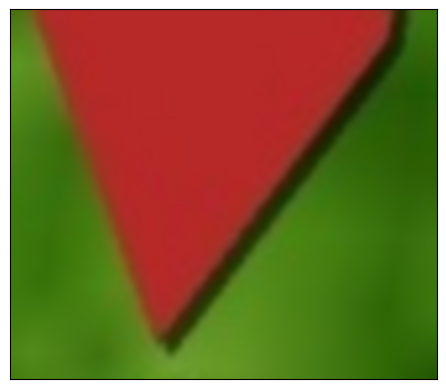

这张没法转捏


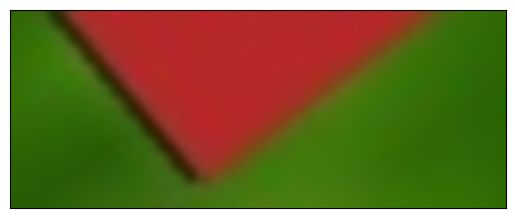

这张没法转捏


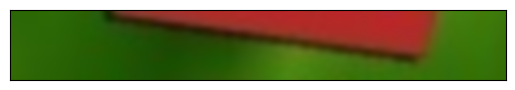

这张没法转捏


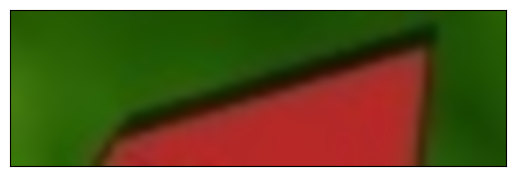

这张没法转捏


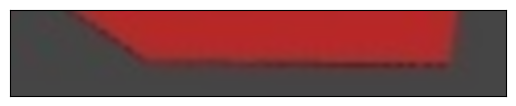

这张没法转捏


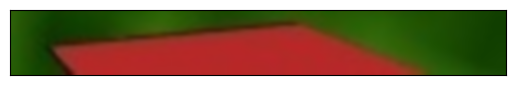

这张没法转捏


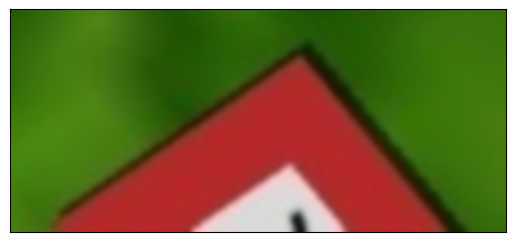

这张没法转捏


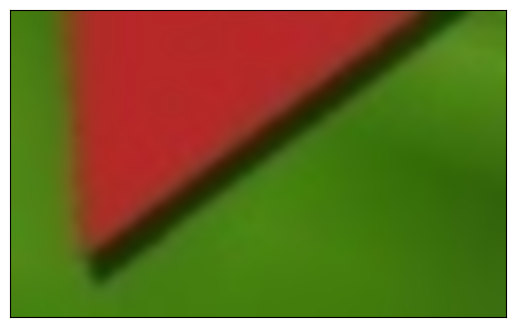

这张没法转捏


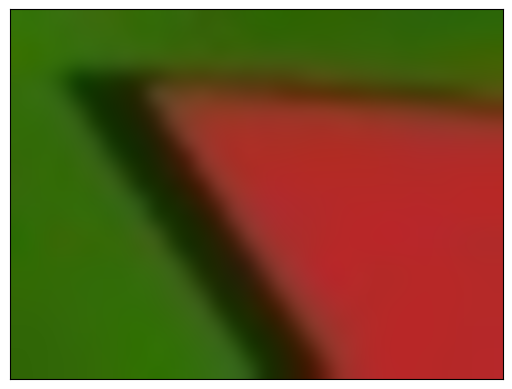

这张没法转捏


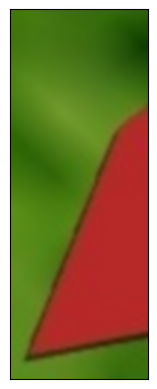

这张没法转捏


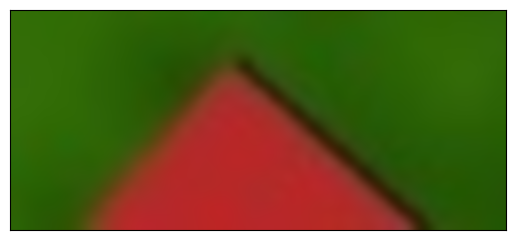

这张没法转捏


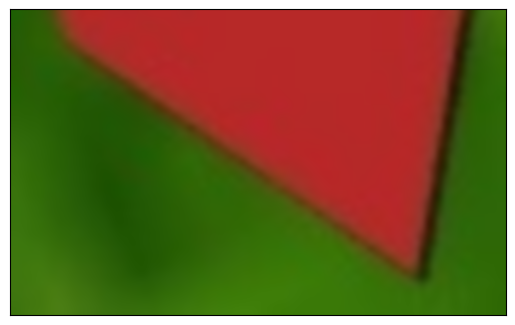

这张没法转捏


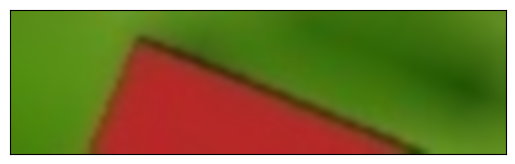

这张没法转捏


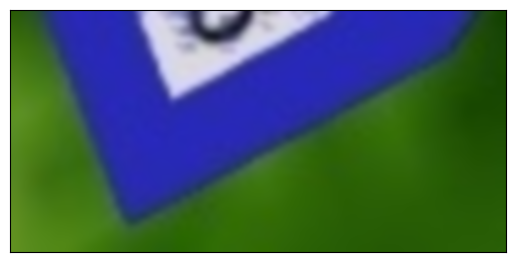

In [12]:
test_dir='datas/images_val/'
test_list=os.listdir(test_dir)
for name in test_list:
    List,im=testshow_all(name,let)

In [38]:
model_test(let,test_loader)


结果验证: 平均损失: 9.870120845,准确率: 5/327 (2%)



In [85]:
model_save(let,'model/1.pth')

In [5]:
model_load(let,'model/1.pth')